In [1]:
import pandas as pd

In [2]:
#Прогнозирование цен на авокадо
#В приложенном файле avocado.csv имеется статистика по продажам авокадо за несколько лет. Нужно сделать прогноз по ценам на авокадо на 2019 год.
#Эта работа основана на данных взятых с https://www.kaggle.com/neuromusic/avocado-prices.
#Запись консультации доступна по ссылке: https://disk.yandex.ru/i/2z-GigKqdvgAyg

# Date - The date of the observation
# AveragePrice - the average price of a single avocado
# type - conventional or organic
# year - the year
# Region - the city or region of the observation
# Total Volume - Total number of avocados sold
# 4046 - Total number of avocados with PLU 4046 sold
# 4225 - Total number of avocados with PLU 4225 sold
# 4770 - Total number of avocados with PLU 4770 sold

df = pd.read_csv("avocado.csv")
# Index(['Code', 'Date', 'AveragePrice', 'Total Volume', 'small Hass',
#        'large Hass', 'extra large Hass', 'Total Bags', 'Small Bags',
#        'Large Bags', 'XLarge Bags', 'type', 'year', 'region'],
#       dtype='object')

In [6]:
df

,Code,Date,AveragePrice,Total Volume,small Hass,large Hass,extra large Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv("avocado.csv")

# Переименование столбцов согласно вашим данным
df = df.rename(columns={
    'small Hass': '4046',
    'large Hass': '4225',
    'extra large Hass': '4770',
    'XLarge Bags': 'XLarge Bags'  # Убедитесь в правильности названия
})

# Преобразование даты
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Фильтрация данных до 2019 года для обучения
# Автоматическое разделение на train/test
last_train_date = df['Date'].max() - pd.DateOffset(weeks=52)  # Последние 52 недели для теста
train_df = df[df['Date'] <= last_train_date]
test_df = df[df['Date'] > last_train_date]

In [ ]:
# Кодирование категориальных переменных
le = LabelEncoder()
train_df['type'] = le.fit_transform(train_df['type'])
test_df['type'] = le.transform(test_df['type'])

# Выбор признаков и целевой переменной (используем переименованные столбцы)
features = ['type', 'year', 'Total Volume', '4046', '4225', '4770']
target = 'AveragePrice'

# Создание лаговых признаков
for lag in [1, 3, 6]:
    train_df[f'price_lag_{lag}'] = train_df.groupby(['region', 'type'])[target].shift(lag)
    test_df[f'price_lag_{lag}'] = test_df.groupby(['region', 'type'])[target].shift(lag)

# Удаление пропусков после создания лагов
train_df = train_df.dropna()

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train_df[features + ['region', 'Date']],
    train_df[target],
    test_size=0.2,
    random_state=42
)

MAE: 0.10530600500417014
RMSE: 0.15249815295781874


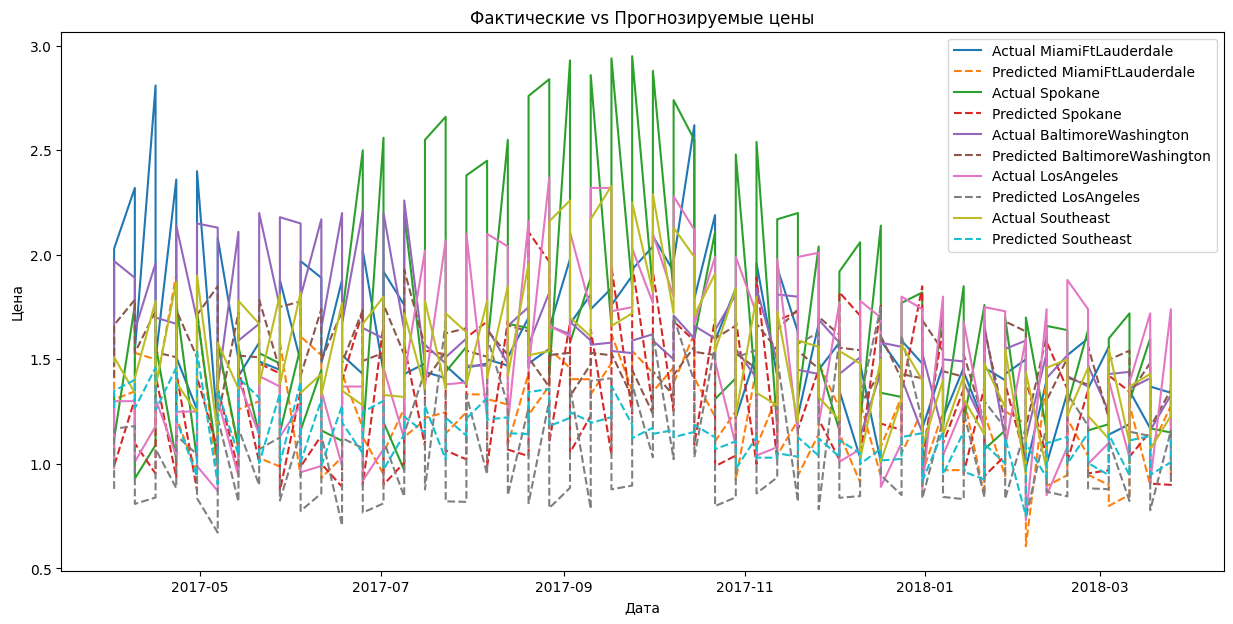

In [16]:
# Кодирование региона
region_encoder = LabelEncoder()
X_train['region'] = region_encoder.fit_transform(X_train['region'])
X_val['region'] = region_encoder.transform(X_val['region'])

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features + ['region']])
X_val_scaled = scaler.transform(X_val[features + ['region']])

# Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Прогнозирование на валидационной выборке
val_pred = model.predict(X_val_scaled)

# Оценка модели
print(f'MAE: {mean_absolute_error(y_val, val_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, val_pred))}')

# Подготовка тестовых данных
test_df = test_df.dropna(subset=features + ['region'])
X_test = test_df[features + ['region', 'Date']].copy()
X_test['region'] = region_encoder.transform(X_test['region'])
X_test_scaled = scaler.transform(X_test[features + ['region']])

# Прогнозирование на 2019 году
test_df['Predicted_Price'] = model.predict(X_test_scaled)

# Визуализация результатов
plt.figure(figsize=(15, 7))
for region in test_df['region'].unique()[:5]:  # Первые 5 регионов
    region_data = test_df[test_df['region'] == region]
    plt.plot(region_data['Date'], region_data['AveragePrice'], label=f'Actual {region}')
    plt.plot(region_data['Date'], region_data['Predicted_Price'], '--', label=f'Predicted {region}')
    
plt.title('Фактические vs Прогнозируемые цены')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()
